<a href="https://colab.research.google.com/github/HinePo/Audio-Data-Analysis-Template/blob/main/Audio_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial from KD Nuggets:

https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

Roadmap:

1. First of all, we need to convert the audio files into PNG format images (spectrograms). From these spectrograms, we have to extract meaningful features, i.e. MFCCs, Spectral Centroid, Zero Crossing Rate, Chroma Frequencies, Spectral Roll-off.

2. Once the features have been extracted, they can be appended into a CSV file so that ANN can be used for classification.

- If we wanna work with image data instead of CSV we will use CNN (Scope of part 2). [worse result, will not be done here]

- The original dataset has 1,2 GB, but I will only use the small version of it (51 MB). Obviously, it will affect the results.

# Import

In [ ]:
# Audio Analysis
import librosa
import librosa.display
import IPython.display as ipd # play the audio in notebook

# Utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pathlib
import csv
from PIL import Image

# preprocessing
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale

# model (Deep Learning)
import keras
from keras import layers
from keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

# librosa usage: some examples

In [ ]:
# load audio
audio_data = '/content/drive/My Drive/Colab Files/mini-genres/classical/classical.00000.au'
x , sr = librosa.load(audio_data)
print(type(x), type(sr))
# This returns an audio time series as a numpy array with a default sampling rate(sr) of 22KHZ mono

<class 'numpy.ndarray'> <class 'int'>


In [ ]:
# play the audio in notebook (returns a widget)
ipd.Audio(x, rate=sr)

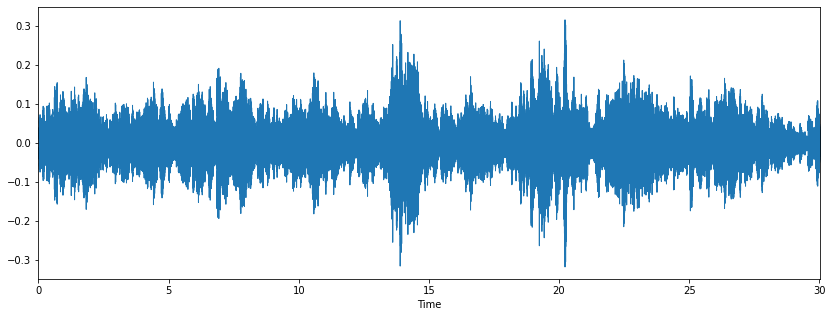

In [ ]:
# plot the audio array
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

## Spectrogram

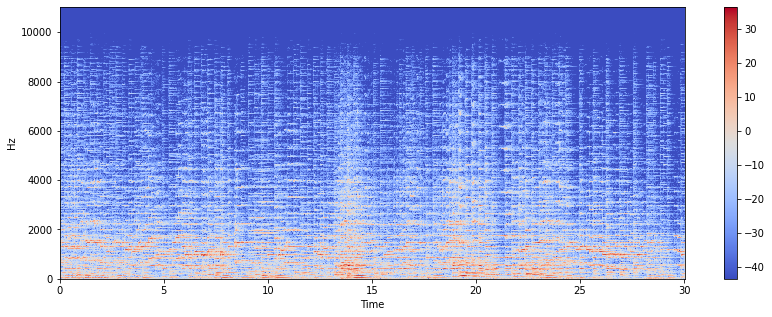

In [ ]:
X = librosa.stft(x) # short-term Fourier transform
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

## Creating audio signal

In [ ]:
pwd

'/content'

In [ ]:
sr = 22050 # sample rate
T = 5.0    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
x1 = 0.5*np.sin(2*np.pi*220*t) # pure sine wave at 220 Hz

# Saving the audio
librosa.output.write_wav('tone_220.wav', x1, sr) # goes to pwd ('/content')

In [ ]:
# Playing the audio created
ipd.Audio(x, rate=sr) # load a NumPy array created

## Feature Extraction

### Spectral Centroid

The spectral centroid indicates at which frequency the energy of a spectrum is centered upon or in other words It indicates where the ” center of mass” for a sound is located.

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0] # extract Spectral Centroid
spectral_centroids.shape

(1293,)

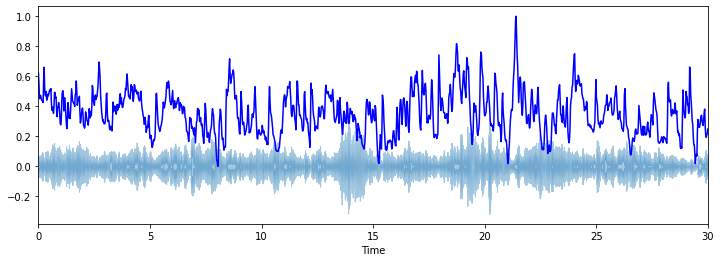

In [ ]:
# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalizing the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

# Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')

### Spectral Rolloff

It is a measure of the shape of the signal. It represents the frequency at which high frequencies decline to 0. To obtain it, we have to calculate the fraction of bins in the power spectrum where 85% of its power is at lower frequencies.

librosa.feature.spectral_rolloff computes the rolloff frequency for each frame in a signal:

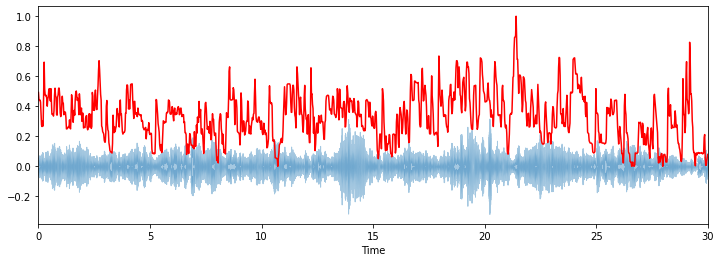

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

### Spectral Bandwidth

The spectral bandwidth is defined as the width of the band of light at one-half the peak maximum (or full width at half maximum [FWHM]) and is represented by the two vertical red lines and λSB on the wavelength axis.

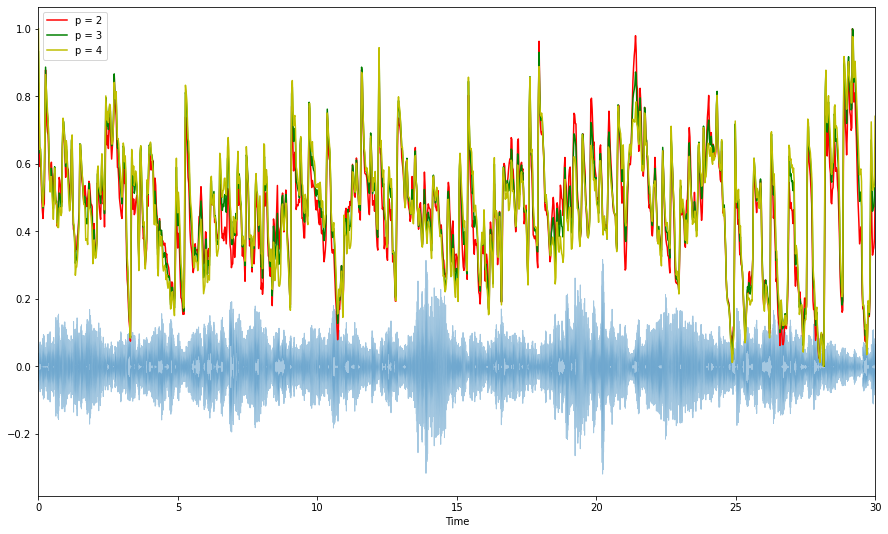

In [ ]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]

plt.figure(figsize=(15, 9))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

### Zero-Crossing Rate

A very simple way for measuring the smoothness of a signal is to calculate the number of zero-crossing within a segment of that signal. A voice signal oscillates slowly — for example, a 100 Hz signal will cross zero 100 per second — whereas an unvoiced fricative can have 3000 zero crossings per second.A very simple way for measuring the smoothness of a signal is to calculate the number of zero-crossing within a segment of that signal. A voice signal oscillates slowly — for example, a 100 Hz signal will cross zero 100 per second — whereas an unvoiced fricative can have 3000 zero crossings per second.

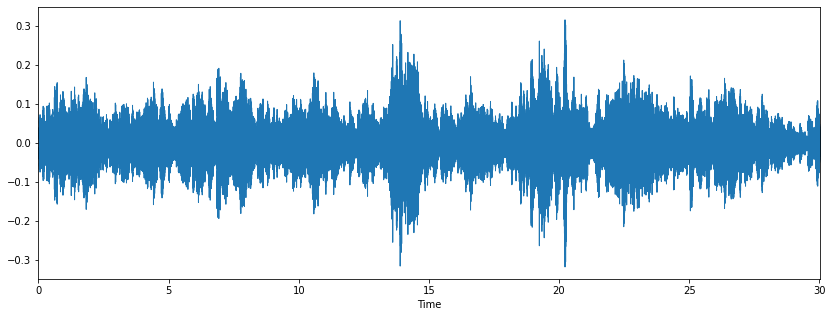

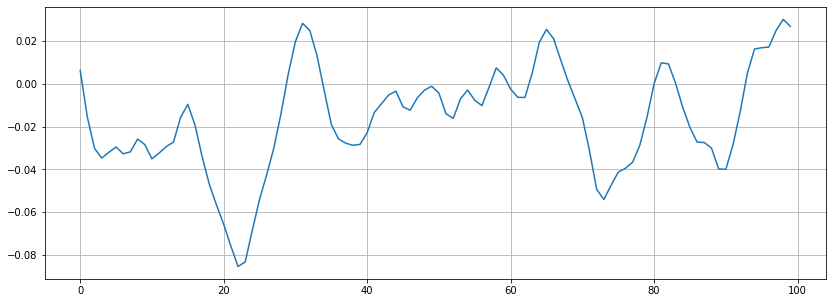

In [ ]:
# Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [ ]:
# count zero-crossings
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

10


### Mel-Frequency Cepstral Coefficients(MFCCs)

The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

In [ ]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

(20, 1293)


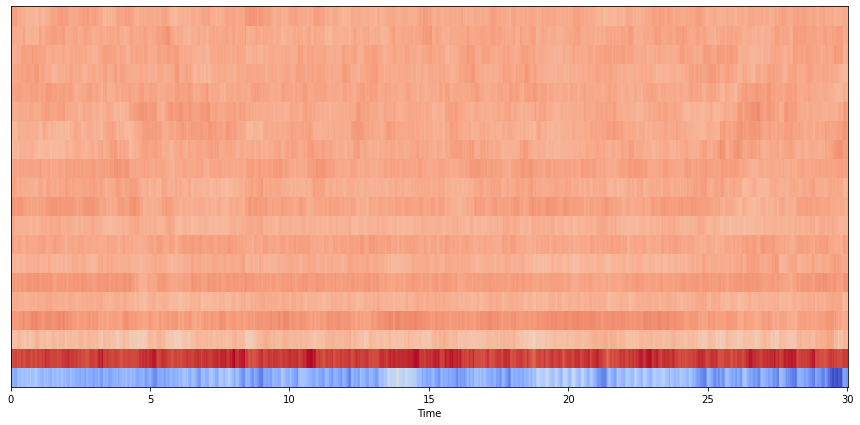

In [ ]:
# Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
# plt.xlim(0,100)

### Chroma Feature

A chroma feature or vector is typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, …, B}, is present in the signal. In short, It provides a robust way to describe a similarity measure between music pieces.

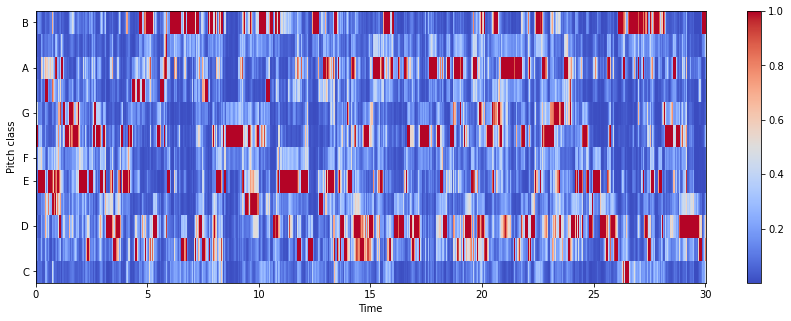

In [ ]:
hop_length = 256
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm') # inferno
plt.colorbar()

# Audio Classification

## Convert audio files into PNG images (extract Spectograms)

In [ ]:
cmap = plt.get_cmap('inferno') # coolwarm
plt.figure(figsize=(8,8))

genres = 'classical jazz metal pop rock'.split() # classes (labels) to classify

for g in genres: # for every genre folder in the dataset
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True) # create dir 'img/data/genre' if it doesn't exist

    for filename in os.listdir(f'/content/drive/My Drive/Colab Files/mini-genres/{g}'): # for every audio file
        songname = f'/content/drive/My Drive/Colab Files/mini-genres/{g}/{filename}' # audio files
        y, sr = librosa.load(songname, mono=True, duration=5) # load audio in an object
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB') # plot spetrogram. we will scale it later
        plt.axis('off')
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png') # save spectrogram as png in pwd ('/content/img_data')
        plt.clf() # Clear the current figure

<Figure size 576x576 with 0 Axes>

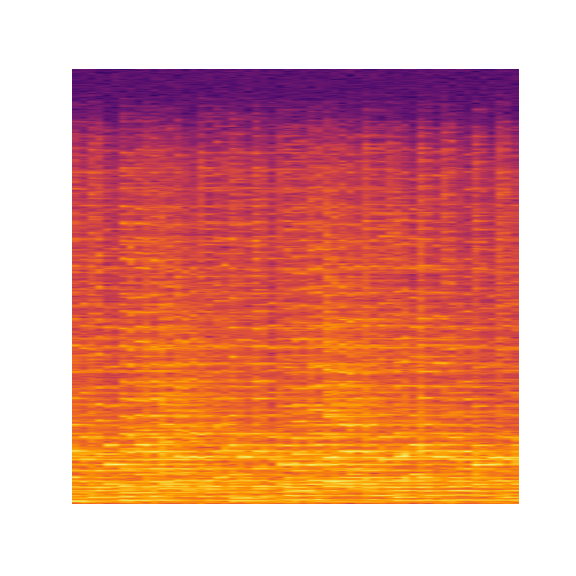

In [ ]:
# visualize one example of spectrogram extracted from audio file and saved in pwd
Image.open('/content/img_data/classical/classical00002.png')

## Create CSV file

Now since all the audio files got converted into their respective spectrograms it’s easier to extract features.

In [ ]:
# create the header for the CSV file
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}' # create columns Mel-Frequency Cepstral Coefficients
header += ' label' # create column with the labels/classes (genres)
header = header.split()

Extracting features from Spectrogram: 
We will extract:
- Mel-frequency cepstral coefficients (MFCC)
- Spectral Centroid
- Zero Crossing Rate
- Chroma Frequencies
- Spectral Roll-off.

In [ ]:
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

genres = 'classical jazz metal pop rock'.split()

for g in genres:
    for filename in os.listdir(f'/content/drive/My Drive/Colab Files/mini-genres/{g}'):
        songname = f'/content/drive/My Drive/Colab Files/mini-genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30) # load audio
        rmse = librosa.feature.rmse(y=y) # compute rmse for each frame

        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) # extract Chroma Feature
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr) # extract Spectral Centroid
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr) # extract Spectral Bandwidth
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr) # extract Spectral Rolloff
        zcr = librosa.feature.zero_crossing_rate(y) # extract Zero-Crossing Rate
        mfcc = librosa.feature.mfcc(y=y, sr=sr) # extract Mel-Frequency Cepstral Coefficients

        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'

        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split()) # CSV file created goes to pwd ('/content/dataset.csv')

## Data preprocessing

It involves loading CSV data, label encoding, feature scaling and data split into training and test set.

In [ ]:
data = pd.read_csv('dataset.csv')
data.head()

filename  chroma_stft      rmse  ...    mfcc19    mfcc20      label
0  classical.00004.au     0.223171  0.042300  ... -4.772360 -4.608322  classical
1  classical.00003.au     0.234236  0.029450  ...  2.334469  2.649742  classical
2  classical.00007.au     0.276529  0.040874  ...  1.097174 -0.294304  classical
3  classical.00002.au     0.277865  0.043869  ... -1.661003 -2.896666  classical
4  classical.00001.au     0.215064  0.030628  ...  2.871973  0.366271  classical

[5 rows x 28 columns]

In [ ]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1) 

In [ ]:
# Encoding the Labels
genre_list = data.iloc[:, -1] # last column
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list) 

# Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float)) # scale everything but the last column (label)

# Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Modeling

In [ ]:
X_train.shape

(40, 26)

In [ ]:
X_train.shape[1]

26

In [ ]:
X_train[1]

array([-0.13540027,  0.9258695 , -0.34068996, -0.60707465, -0.39656055,
       -0.17711476,  0.70615517,  0.60406424, -1.57779691,  0.91819443,
       -1.2973024 , -0.3335033 , -1.10888189,  0.83266612, -0.85787983,
       -0.50869776, -1.31211498, -0.38331731, -1.55348029, -0.52023082,
        0.56574879, -1.56611489, -1.24506838, -0.64747374, -0.34756926,
       -0.72215022])

In [ ]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)
checkpoint = keras.callbacks.ModelCheckpoint(filepath='/content',
                                             monitor='val_accuracy',
                                             mode='max')

In [ ]:
classifier = model.fit(X_train, y_train,
                       epochs=100, batch_size=128,
                       validation_split = 0.2, # split to get validation columns in history variable, then plot
                       callbacks=[early_stopping, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 2.3253 - accuracy: 0.0312WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/assets
1/1 [==============================] - 1s 785ms/step - loss: 2.3253 - accuracy: 0.0312 - val_loss: 2.0909 - val_accuracy: 0.2500
Epoch 2/100
1/1 [==============================] - 1s 523ms/step - loss: 2.1172 - accuracy: 0.3125 - val_loss: 1.9381 - val_accuracy: 0.3750
Epoch 3/100
1/1 [==============================] - 1s 505ms/step - loss: 1.9384 - accuracy: 0.4688 - val_loss: 1.79

In [ ]:
# evaluate method uses the defined metrics
loss, acc = model.evaluate(X_test, y_test, verbose = 2)

print("Testing set Accuracy: {:5.4f}".format(acc))
print("Testing set Loss: {:5.2f}".format(loss))

1/1 - 0s - loss: 0.1175 - accuracy: 0.9000
Testing set Accuracy: 0.9000
Testing set Loss:  0.12


In [ ]:
hist = pd.DataFrame(classifier.history)
hist['epoch'] = classifier.epoch
hist.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'epoch'], dtype='object')

### Plot

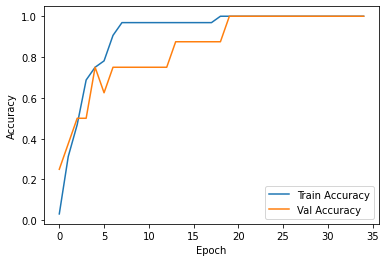

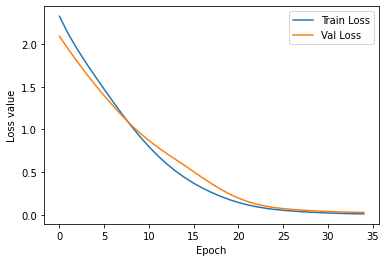

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel("Accuracy")
  plt.plot(hist['epoch'], hist['accuracy'], label = 'Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Accuracy')
  plt.legend()
  #plt.xlim([0, 200])

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel("Loss value")
  plt.plot(hist['epoch'], hist['loss'], label = 'Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Loss')
  plt.legend()
  #plt.xlim([0, 200])

plot_history(classifier)